## Load Libraries

In [1]:
# To store data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# To create nicer plots
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To get new datatypes and functions
from collections import Counter
from cycler import cycler

# To measure time
from time import time

# To do signal processing
from scipy import signal

In [2]:
# check data
def plot_matrix(mat, axis, title):
    rows, cols = mat.shape
    x = np.expand_dims(range(cols), axis=1).repeat(rows, axis=1)
    y = mat.T
    axis.plot(x, y)
    axis.set_title(title)

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

## Load Data

TODO: df_records缺少id信息，加入id信息以便分组

In [3]:
df_records_cotton = pd.read_csv('/data/data/with-zhangchu/results/df_records_cotton.csv')

X_columns = [c for c in df_records_cotton.columns if 'band_' in c]
y_column  = 'subtype'

subtype_counts = df_records_cotton[y_column].value_counts()

## Data Transformation

### Original

In [4]:
df_original = df_records_cotton.loc[:, X_columns]
df_original["trans_type"] = 0

### Noise addition

In this transformation, random noise from a Gaussian distribution, $N(t)$, is added to the original signal $S(t)$. $N(t)$ is obtained from a random noise generator where the mean of the distribution is set to 0, and the standard deviation to 􏰁$\sqrt{E_{Navg}}$. Here, $E_{Navg}=10^{(E_{Savg}-\alpha)/10}$, where $E_{Savg}$ is the average power of $S(t)$ and $\alpha$ is the desired Signal to Noise Savg Ratio (SNR). Finally the noise-added signal is generated as $S(t)$ + $N(t)$.

In [5]:
import random

def add_gaussian_noise(x, alpha):
    """ add gaussian noise on original signal.
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    E_avg_pow = np.dot(x, x) # average power of S(t)
    N = [random.gauss(0, np.sqrt(10**((E_avg_pow - alpha) / 10))) for i in range(len(x))]
    return N

df_noise_addition = df_original[X_columns].apply(lambda x: x + add_gaussian_noise(x, 80), axis=1)
df_noise_addition["trans_type"] = 1

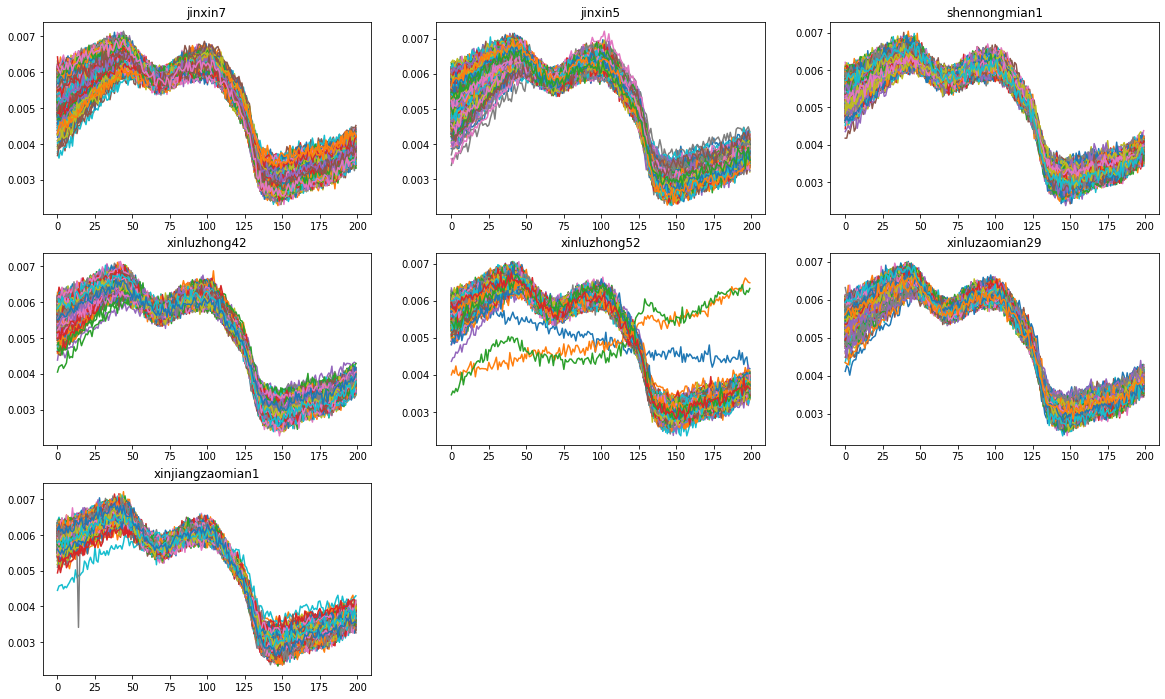

In [84]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = trim_axs(axes, 7)
for ax, index in zip(axes, subtype_counts.index):
    df_plot = df_noise_addition.loc[df_records_cotton[y_column] == index, X_columns]
    plot_matrix(df_plot.values, ax, index)
plt.show()

### Scaling

The original magnitude of the ECG S(t) is transformed as β × S(t), where β > 0 and β is the manually assigned scaling factor.

In [6]:
beta = 0.8
df_scaling = df_original[X_columns].apply(lambda x: x * beta, axis=1)
df_scaling["trans_type"] = 2

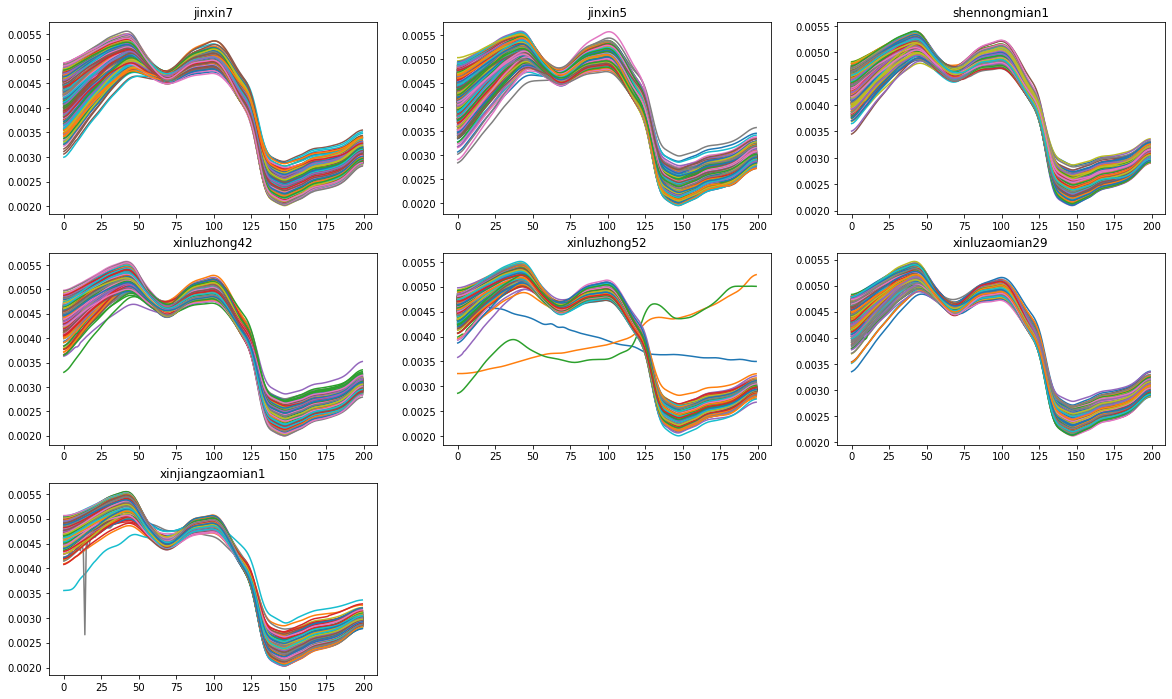

In [88]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = trim_axs(axes, 7)
for ax, index in zip(axes, subtype_counts.index):
    df_plot = df_scaling.loc[df_records_cotton[y_column] == index, X_columns]
    plot_matrix(df_plot.values, ax, index)
plt.show()

### Nagation

The original amplitude of the $S(t)$ is multiplied by −1, causing a spatial inversion of the time-series. The transformed signal can be mathematically expressed as $-S(t)$.

In [7]:
df_nagation = df_original[X_columns].apply(lambda x: -x, axis=1)
df_nagation["trans_type"] = 3

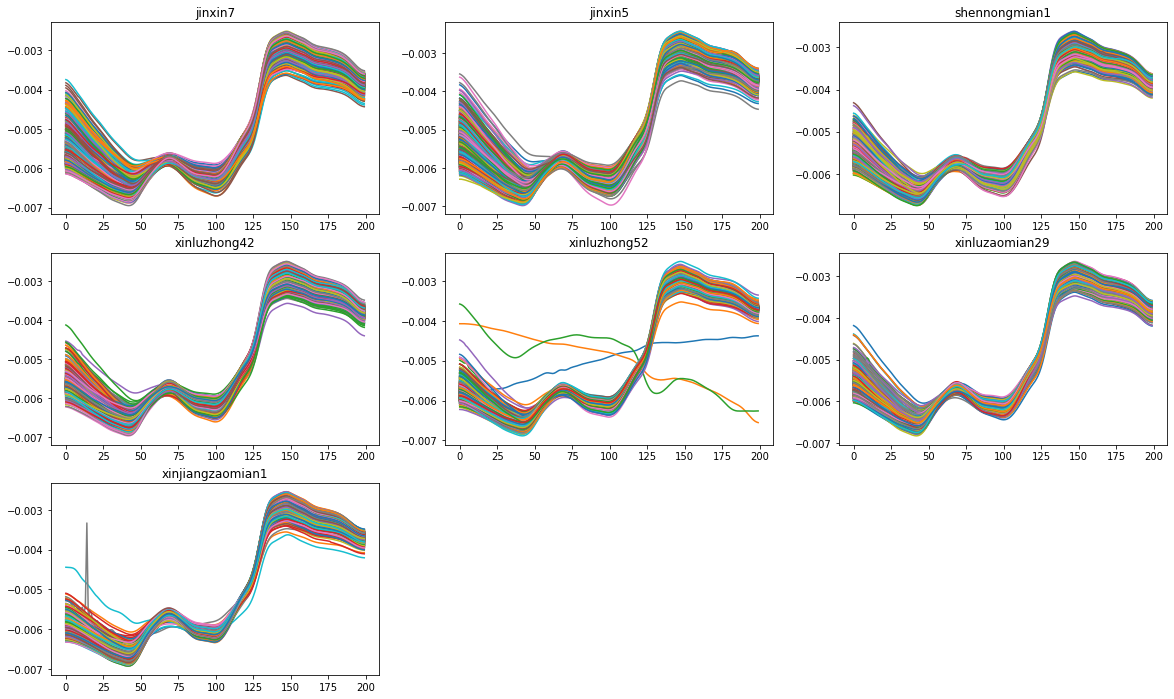

In [93]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = trim_axs(axes, 7)
for ax, index in zip(axes, subtype_counts.index):
    df_plot = df_nagation.loc[df_records_cotton[y_column] == index, X_columns]
    plot_matrix(df_plot.values, ax, index)
plt.show()

### Temporal Inversion
Given the original signal $S(t)$, where t = 1, 2, ..., N and N is the length of the time-series, the temporally inverted version of the signal is expressed as $S^`(t)$, where t = N, N − 1, ..., 1.

In [8]:
df_temporal_inversion = df_original[X_columns].apply(lambda x: x[::-1], axis=1)
df_temporal_inversion["trans_type"] = 4

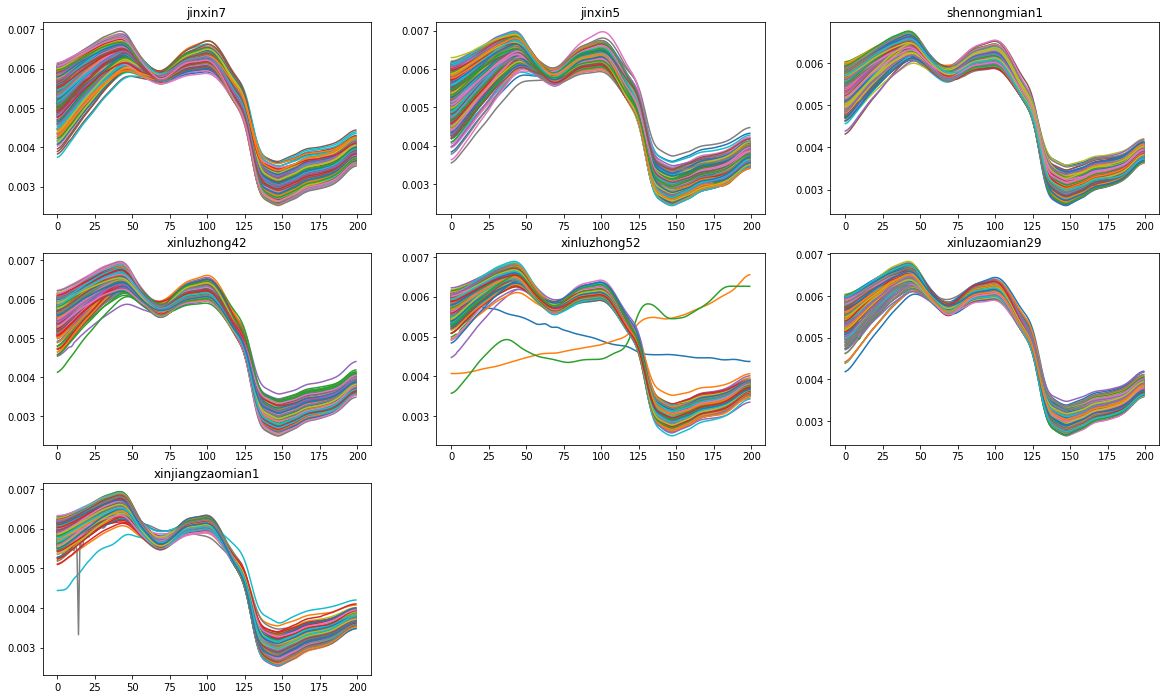

In [97]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = trim_axs(axes, 7)
for ax, index in zip(axes, subtype_counts.index):
    df_plot = df_temporal_inversion.loc[df_records_cotton[y_column] == index, X_columns]
    plot_matrix(df_plot.values, ax, index)
plt.show()

### Permutation
The original $S(t)$, is divided into m segments and shuffled, randomly perturbing the temporal location of each segment. Let’s assume $S(t)$ is expressed as $S(t) = [s_i(t)|i = 1, 2, ..., m]$, a sequence of segments with segment numbers $i = 1, 2, ..., m$. Accordingly, the permuted signal $Sp(t)$ can be obtained as $Sp(t) = [s_i(t)]$, where the sequence of $i = 1, 2, ..., m$ is randomly shuffled.

In [5]:
def permute(x, num_segments):
    segment_size = int(len(x) / num_segments)
    segment_order = np.random.default_rng().permutation(num_segments).reshape(-1, 1)
    segment_order = (segment_order.repeat(segment_size, axis=1) * segment_size + range(segment_size)).flatten()
    return segment_order

num_segments = 10

df_permutation = df_original[X_columns].apply(lambda x: x[permute(x, num_segments)], axis=1)

df_permutation["trans_type"] = 5

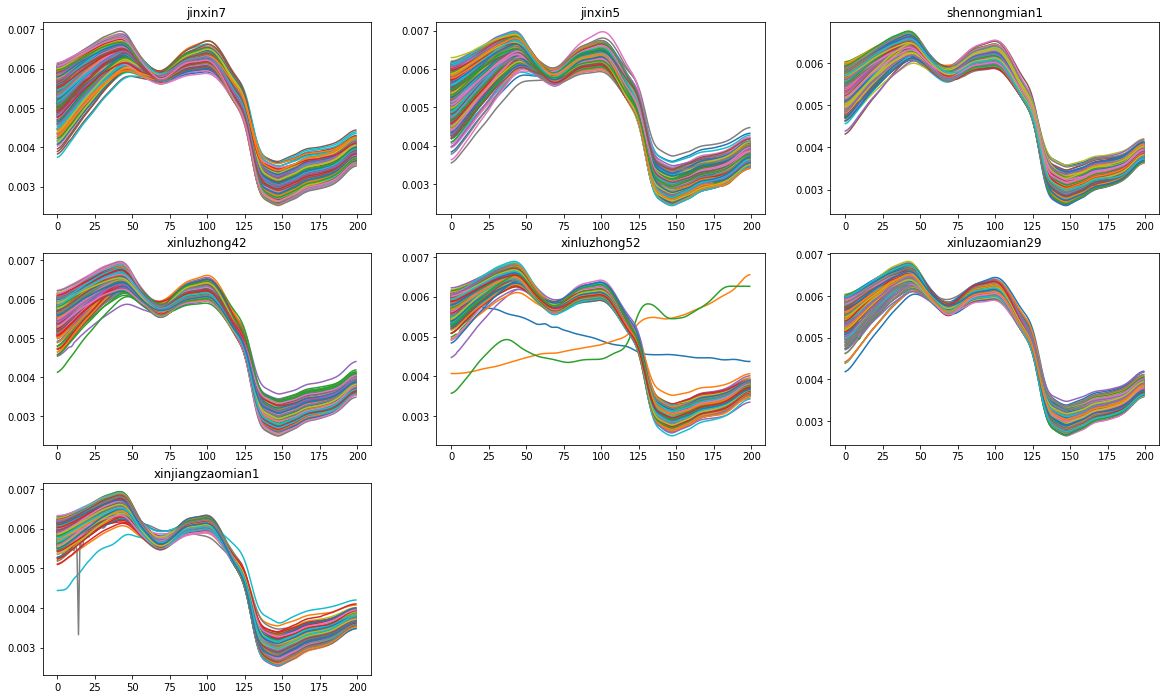

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = trim_axs(axes, 7)
for ax, index in zip(axes, subtype_counts.index):
    df_plot = df_permutation.loc[df_records_cotton[y_column] == index, X_columns]
    plot_matrix(df_plot.values, ax, index)
plt.show()

### Time-warping

Randomly selected segments of the original ECG signals $S(t)$ are stretched or squeezed along the x (time) axis. Let’s assume Φ(S(t), k) is an interpolation-based time-warping function where k is the stretch factor (with the corresponding squeeze factor represented as 1/k). If the signal, S(t), is expressed as S(t) = [si(t)|i = 1, 2, ..., m], a sequence of segments with segment numbers i = 1, 2, ..., m, the time-warped (transformed) signal T (t) is obtained by applying Φ(si(t),k) to half of the segments selected randomly, and Φ(sj(t),1/k) to the other half of the segments where i ̸= j. Where T(t) becomes longer or shorter than S(t) due to the even or odd nature of m, T(t) is clipped or zero-padded accordingly to maintain the original input length.

In [12]:
num_segments = 20
segment_size = int(200 / num_segments)

segment_order = np.random.default_rng().permutation(num_segments)

arr_list = []
for index, so in enumerate(segment_order):
    num_sample = int(segment_size / 2) if index < int(num_segments / 2) else int(segment_size * 2)
    segment_range = range(index * segment_size, (index + 1) * segment_size)
    segment_trans = df_original.iloc[:, segment_range].apply(lambda x: signal.resample(x, num_sample), axis=1)
    arr_list.append(np.stack(segment_trans))

arr = np.concatenate(arr_list, axis=1)
arr = arr[:, 25:225]
df_time_warping = pd.DataFrame(arr, columns=X_columns)
df_time_warping["trans_type"] = 6

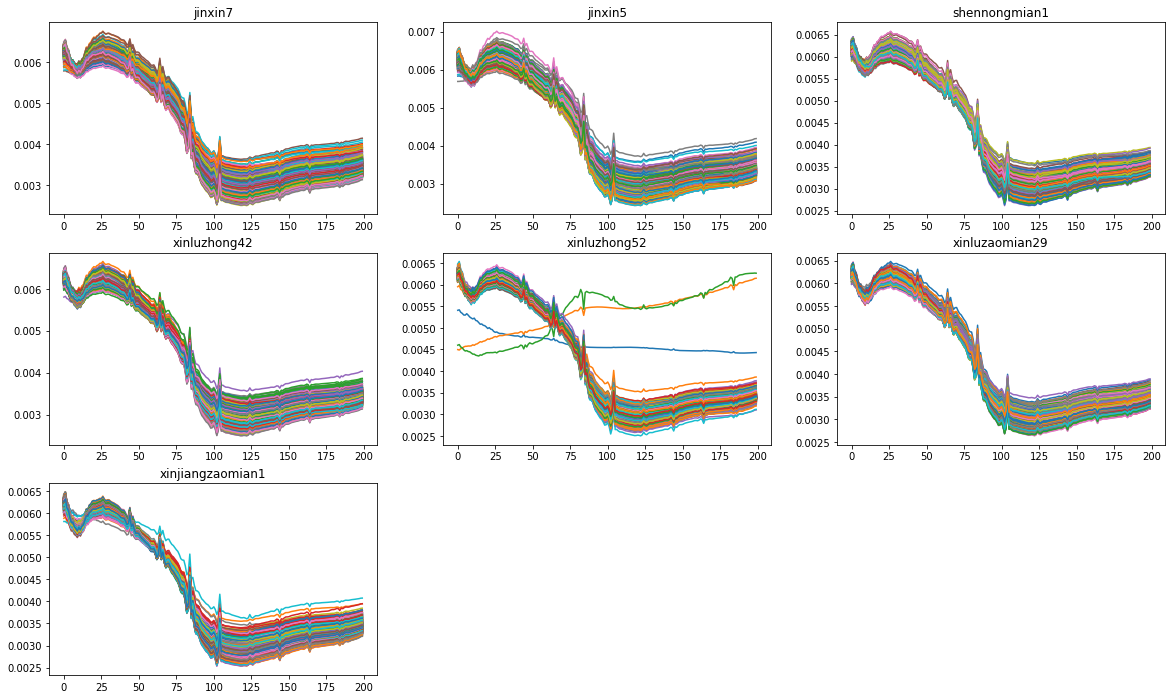

In [101]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = trim_axs(axes, 7)
for ax, index in zip(axes, subtype_counts.index):
    df_plot = df_time_warping.loc[df_records_cotton[y_column] == index, X_columns]
    plot_matrix(df_plot.values, ax, index)
plt.show()

### Fancy PCA

### Others?

is there any other transformations?

- Fancy PCA
- SVD

### Concatenate dataframes

In [13]:
df_records_cotton_self_supervised = pd.concat([df_original, df_noise_addition,
                                               df_scaling, df_nagation, df_temporal_inversion,
                                               df_permutation, df_time_warping], axis=0)

In [17]:
df_records_cotton_self_supervised.to_csv("/data/data/with-zhangchu/results/df_records_cotton_self_supervised.csv",
                                         index=None)